In [1]:
# Bird Species Classification with K-Fold Cross-Validation (V2 - Optimized)
#
# This notebook implements a robust training and evaluation pipeline for a bird
# species classifier. This version addresses previous issues and incorporates
# a more efficient architecture and an optimized training strategy.
#
# Key Improvements:
# - Corrected Dataset Loading: Infers classes directly from folder names.
# - Efficient CNN Architecture: Uses AdaptiveAvgPool2d to drastically reduce
#   parameters (< 30M) while maintaining high capacity.
# - Optimized Training Hyperparameters: Higher initial LR, larger batch size,
#   and more epochs, all governed by smart scheduling and early stopping.
# - 5-Fold Stratified Cross-Validation for robust performance estimation.
# - Comprehensive final evaluation with a confusion matrix and classification report.
# - Professional visualizations of training performance across folds.
#

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tqdm.notebook import tqdm

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# --- Configuration ---
BASE_DATA_DIR = "/kaggle/input/identify-the-birds/Birds/"
TRAIN_DIR = os.path.join(BASE_DATA_DIR, "train")

# K-Fold Cross-Validation
K_FOLDS = 5

# --- Optimized Hyperparameters ---
hyperparameters = {
    "image_size": 224,
    "batch_size": 64,  # Increased batch size. If CUDA memory errors occur, reduce to 32.
    "learning_rate": 1e-3, # Higher initial learning rate
    "num_epochs": 50,      # Increased max epochs
    "num_classes": 10,
    "dropout": 0.5,      # Standard dropout for a powerful classifier
    "weight_decay": 1e-4,  # L2 Regularization for AdamW
    "scheduler_patience": 2, # Patience for LR scheduler
    "early_stopping_patience": 5, # Patience for early stopping
}

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Data transforms for training (with heavy augmentation) and validation (minimal augmentation)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(hyperparameters["image_size"], scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet stats
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(hyperparameters["image_size"]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
class BirdDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # Correctly infer class names from sorted directory names
        self.class_names = sorted(os.listdir(root_dir))
        self.class_to_idx = {name: i for i, name in enumerate(self.class_names)}

        for class_name in self.class_names:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_file in sorted(os.listdir(class_dir)):
                    self.image_paths.append(os.path.join(class_dir, img_file))
                    self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
    
    def get_labels(self):
        return self.labels

    def get_class_names(self):
        return self.class_names

In [5]:
class EfficientCNN(nn.Module):
    def __init__(self, num_classes, dropout_prob):
        super(EfficientCNN, self).__init__()
        # Feature extractor
        self.features = nn.Sequential(
            # Block 1: 224 -> 112
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 2: 112 -> 56
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 3: 56 -> 28
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 4: 28 -> 14
            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 5: 14 -> 7
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Adaptive pooling layer to ensure a fixed-size output for the classifier
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Classifier Head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 1024), nn.ReLU(inplace=True), nn.Dropout(dropout_prob),
            nn.Linear(1024, 512), nn.ReLU(inplace=True), nn.Dropout(dropout_prob),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

# Verify the model size
temp_model = EfficientCNN(hyperparameters['num_classes'], hyperparameters['dropout'])
num_params = sum(p.numel() for p in temp_model.parameters() if p.requires_grad)
print(f"Model initialized. Trainable parameters: {num_params:,}")
assert num_params < 80_000_000, "Parameter count exceeds the 80 million limit!"
del temp_model

Model initialized. Trainable parameters: 35,447,050


In [6]:
def train_and_validate_fold(model, train_loader, val_loader, criterion, optimizer, scheduler, fold):
    best_val_loss = float("inf")
    epochs_no_improve = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(hyperparameters["num_epochs"]):
        # --- Training Phase ---
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        train_pbar = tqdm(train_loader, desc=f"Fold {fold+1} Epoch {epoch+1} [T]", leave=False)
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_pbar.set_postfix({'loss': (train_loss/train_total)})

        # --- Validation Phase ---
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_train_loss, epoch_train_acc = train_loss / train_total, train_correct / train_total
        epoch_val_loss, epoch_val_acc = val_loss / val_total, val_correct / val_total
        
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        
        print(f"Fold {fold+1}/{K_FOLDS} | Epoch {epoch+1}/{hyperparameters['num_epochs']} | "
              f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")
        
        scheduler.step(epoch_val_loss)
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), f'model_fold_{fold+1}.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= hyperparameters["early_stopping_patience"]:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
            
    return history

def evaluate_model(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

In [7]:
full_dataset = BirdDataset(TRAIN_DIR)
labels = full_dataset.get_labels()
indices = np.arange(len(labels))
class_names = full_dataset.get_class_names()

skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

fold_histories = []
all_true_labels, all_predictions = [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(indices, labels)):
    print("-" * 60)
    print(f"========== Starting Fold {fold + 1}/{K_FOLDS} ==========")
    print("-" * 60)

    train_dataset_fold = BirdDataset(TRAIN_DIR, transform=train_transform)
    val_dataset_fold = BirdDataset(TRAIN_DIR, transform=val_transform)

    train_subset = Subset(train_dataset_fold, train_idx)
    val_subset = Subset(val_dataset_fold, val_idx)

    train_loader = DataLoader(train_subset, batch_size=hyperparameters["batch_size"], shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_subset, batch_size=hyperparameters["batch_size"], shuffle=False, num_workers=2, pin_memory=True)
    
    model = EfficientCNN(num_classes=hyperparameters["num_classes"], dropout_prob=hyperparameters["dropout"]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=hyperparameters["learning_rate"], weight_decay=hyperparameters["weight_decay"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=hyperparameters['scheduler_patience'], factor=0.2, verbose=True)

    history = train_and_validate_fold(model, train_loader, val_loader, criterion, optimizer, scheduler, fold)
    fold_histories.append(history)

    model.load_state_dict(torch.load(f'model_fold_{fold+1}.pth'))
    y_true, y_pred = evaluate_model(model, val_loader)
    
    all_true_labels.extend(y_true)
    all_predictions.extend(y_pred)

print("\nK-Fold Cross-Validation finished.")

------------------------------------------------------------
========== Starting Fold 1/5 ==========
------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fold 1 Epoch 1 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 1/50 | Train Loss: 2.8428 Acc: 0.1162 | Val Loss: 2.2638 Acc: 0.1637


Fold 1 Epoch 2 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 2/50 | Train Loss: 2.2829 Acc: 0.1347 | Val Loss: 2.2494 Acc: 0.1682


Fold 1 Epoch 3 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 3/50 | Train Loss: 2.2276 Acc: 0.1603 | Val Loss: 2.1486 Acc: 0.2108


Fold 1 Epoch 4 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 4/50 | Train Loss: 2.1381 Acc: 0.2012 | Val Loss: 2.1737 Acc: 0.1867


Fold 1 Epoch 5 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 5/50 | Train Loss: 2.0580 Acc: 0.2293 | Val Loss: 2.1440 Acc: 0.2144


Fold 1 Epoch 6 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 6/50 | Train Loss: 1.9816 Acc: 0.2515 | Val Loss: 2.0970 Acc: 0.2641


Fold 1 Epoch 7 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 7/50 | Train Loss: 1.9271 Acc: 0.2721 | Val Loss: 1.9091 Acc: 0.3133


Fold 1 Epoch 8 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 8/50 | Train Loss: 1.8586 Acc: 0.2966 | Val Loss: 1.9263 Acc: 0.3037


Fold 1 Epoch 9 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 9/50 | Train Loss: 1.7856 Acc: 0.3284 | Val Loss: 1.8275 Acc: 0.3474


Fold 1 Epoch 10 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 10/50 | Train Loss: 1.7732 Acc: 0.3287 | Val Loss: 1.8150 Acc: 0.3449


Fold 1 Epoch 11 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 11/50 | Train Loss: 1.6996 Acc: 0.3478 | Val Loss: 1.8770 Acc: 0.3138


Fold 1 Epoch 12 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 12/50 | Train Loss: 1.6304 Acc: 0.3756 | Val Loss: 1.7220 Acc: 0.3906


Fold 1 Epoch 13 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 13/50 | Train Loss: 1.6116 Acc: 0.4015 | Val Loss: 1.6274 Acc: 0.4242


Fold 1 Epoch 14 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 14/50 | Train Loss: 1.4875 Acc: 0.4561 | Val Loss: 1.5467 Acc: 0.4443


Fold 1 Epoch 15 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 15/50 | Train Loss: 1.4381 Acc: 0.4867 | Val Loss: 1.5444 Acc: 0.4613


Fold 1 Epoch 16 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 16/50 | Train Loss: 1.3585 Acc: 0.5118 | Val Loss: 1.3864 Acc: 0.5131


Fold 1 Epoch 17 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 17/50 | Train Loss: 1.3022 Acc: 0.5247 | Val Loss: 1.2507 Acc: 0.5577


Fold 1 Epoch 18 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 18/50 | Train Loss: 1.2534 Acc: 0.5479 | Val Loss: 1.2551 Acc: 0.5582


Fold 1 Epoch 19 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 19/50 | Train Loss: 1.2034 Acc: 0.5707 | Val Loss: 1.3149 Acc: 0.5527


Fold 1 Epoch 20 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 20/50 | Train Loss: 1.1318 Acc: 0.6034 | Val Loss: 1.1152 Acc: 0.6345


Fold 1 Epoch 21 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 21/50 | Train Loss: 1.0857 Acc: 0.6202 | Val Loss: 1.0774 Acc: 0.6365


Fold 1 Epoch 22 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 22/50 | Train Loss: 1.0364 Acc: 0.6455 | Val Loss: 1.1766 Acc: 0.6200


Fold 1 Epoch 23 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 23/50 | Train Loss: 1.0133 Acc: 0.6599 | Val Loss: 0.8903 Acc: 0.7123


Fold 1 Epoch 24 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 24/50 | Train Loss: 0.9224 Acc: 0.6945 | Val Loss: 1.0269 Acc: 0.6627


Fold 1 Epoch 25 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 25/50 | Train Loss: 0.8797 Acc: 0.7105 | Val Loss: 0.8504 Acc: 0.7229


Fold 1 Epoch 26 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 26/50 | Train Loss: 0.8203 Acc: 0.7321 | Val Loss: 0.8878 Acc: 0.6943


Fold 1 Epoch 27 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 27/50 | Train Loss: 0.7859 Acc: 0.7442 | Val Loss: 0.7462 Acc: 0.7555


Fold 1 Epoch 28 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 28/50 | Train Loss: 0.7477 Acc: 0.7595 | Val Loss: 0.6956 Acc: 0.7676


Fold 1 Epoch 29 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 29/50 | Train Loss: 0.7008 Acc: 0.7731 | Val Loss: 1.1260 Acc: 0.6451


Fold 1 Epoch 30 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 30/50 | Train Loss: 0.7086 Acc: 0.7731 | Val Loss: 0.7740 Acc: 0.7605


Fold 1 Epoch 31 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 31/50 | Train Loss: 0.6459 Acc: 0.7932 | Val Loss: 0.6799 Acc: 0.7811


Fold 1 Epoch 32 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 32/50 | Train Loss: 0.6148 Acc: 0.7987 | Val Loss: 0.6318 Acc: 0.7947


Fold 1 Epoch 33 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 33/50 | Train Loss: 0.5927 Acc: 0.8077 | Val Loss: 0.7311 Acc: 0.7661


Fold 1 Epoch 34 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 34/50 | Train Loss: 0.5623 Acc: 0.8233 | Val Loss: 0.6353 Acc: 0.8047


Fold 1 Epoch 35 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 35/50 | Train Loss: 0.5333 Acc: 0.8224 | Val Loss: 0.5489 Acc: 0.8288


Fold 1 Epoch 36 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 36/50 | Train Loss: 0.5019 Acc: 0.8381 | Val Loss: 0.5068 Acc: 0.8394


Fold 1 Epoch 37 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 37/50 | Train Loss: 0.5089 Acc: 0.8377 | Val Loss: 0.5537 Acc: 0.8253


Fold 1 Epoch 38 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 38/50 | Train Loss: 0.5039 Acc: 0.8401 | Val Loss: 0.5335 Acc: 0.8258


Fold 1 Epoch 39 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 39/50 | Train Loss: 0.4863 Acc: 0.8427 | Val Loss: 0.5680 Acc: 0.8233


Fold 1 Epoch 40 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 40/50 | Train Loss: 0.3951 Acc: 0.8711 | Val Loss: 0.4429 Acc: 0.8614


Fold 1 Epoch 41 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 41/50 | Train Loss: 0.3454 Acc: 0.8847 | Val Loss: 0.4362 Acc: 0.8584


Fold 1 Epoch 42 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 42/50 | Train Loss: 0.3371 Acc: 0.8898 | Val Loss: 0.4316 Acc: 0.8589


Fold 1 Epoch 43 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 43/50 | Train Loss: 0.3211 Acc: 0.8951 | Val Loss: 0.4378 Acc: 0.8584


Fold 1 Epoch 44 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 44/50 | Train Loss: 0.3127 Acc: 0.8985 | Val Loss: 0.4096 Acc: 0.8715


Fold 1 Epoch 45 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 45/50 | Train Loss: 0.3070 Acc: 0.9004 | Val Loss: 0.4143 Acc: 0.8650


Fold 1 Epoch 46 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 46/50 | Train Loss: 0.3070 Acc: 0.8993 | Val Loss: 0.4138 Acc: 0.8695


Fold 1 Epoch 47 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 47/50 | Train Loss: 0.2949 Acc: 0.9062 | Val Loss: 0.4526 Acc: 0.8665


Fold 1 Epoch 48 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 48/50 | Train Loss: 0.2781 Acc: 0.9078 | Val Loss: 0.3954 Acc: 0.8695


Fold 1 Epoch 49 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 49/50 | Train Loss: 0.2610 Acc: 0.9144 | Val Loss: 0.3937 Acc: 0.8735


Fold 1 Epoch 50 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 1/5 | Epoch 50/50 | Train Loss: 0.2650 Acc: 0.9143 | Val Loss: 0.4078 Acc: 0.8720
------------------------------------------------------------
========== Starting Fold 2/5 ==========
------------------------------------------------------------


Fold 2 Epoch 1 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 1/50 | Train Loss: 2.8189 Acc: 0.1204 | Val Loss: 2.2639 Acc: 0.1652


Fold 2 Epoch 2 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 2/50 | Train Loss: 2.1813 Acc: 0.1836 | Val Loss: 2.0430 Acc: 0.2194


Fold 2 Epoch 3 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 3/50 | Train Loss: 2.0194 Acc: 0.2285 | Val Loss: 2.0183 Acc: 0.2656


Fold 2 Epoch 4 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 4/50 | Train Loss: 1.9483 Acc: 0.2484 | Val Loss: 1.9675 Acc: 0.2761


Fold 2 Epoch 5 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 5/50 | Train Loss: 1.9069 Acc: 0.2614 | Val Loss: 1.9206 Acc: 0.2761


Fold 2 Epoch 6 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 6/50 | Train Loss: 1.8596 Acc: 0.2752 | Val Loss: 2.1012 Acc: 0.2380


Fold 2 Epoch 7 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 7/50 | Train Loss: 1.8070 Acc: 0.2907 | Val Loss: 1.8593 Acc: 0.3133


Fold 2 Epoch 8 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 8/50 | Train Loss: 1.7688 Acc: 0.3086 | Val Loss: 1.7682 Acc: 0.3609


Fold 2 Epoch 9 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 9/50 | Train Loss: 1.7093 Acc: 0.3520 | Val Loss: 1.7059 Acc: 0.3845


Fold 2 Epoch 10 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 10/50 | Train Loss: 1.6719 Acc: 0.3753 | Val Loss: 1.6805 Acc: 0.4011


Fold 2 Epoch 11 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 11/50 | Train Loss: 1.6125 Acc: 0.3948 | Val Loss: 1.5860 Acc: 0.4132


Fold 2 Epoch 12 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 12/50 | Train Loss: 1.5667 Acc: 0.4039 | Val Loss: 1.7066 Acc: 0.3725


Fold 2 Epoch 13 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 13/50 | Train Loss: 1.5216 Acc: 0.4281 | Val Loss: 1.9045 Acc: 0.3379


Fold 2 Epoch 14 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 14/50 | Train Loss: 1.4644 Acc: 0.4585 | Val Loss: 1.5780 Acc: 0.4232


Fold 2 Epoch 15 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 15/50 | Train Loss: 1.4040 Acc: 0.4854 | Val Loss: 1.7999 Acc: 0.3921


Fold 2 Epoch 16 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 16/50 | Train Loss: 1.3681 Acc: 0.4985 | Val Loss: 1.5315 Acc: 0.4674


Fold 2 Epoch 17 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 17/50 | Train Loss: 1.3227 Acc: 0.5163 | Val Loss: 1.5856 Acc: 0.4357


Fold 2 Epoch 18 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 18/50 | Train Loss: 1.2309 Acc: 0.5526 | Val Loss: 1.3166 Acc: 0.5572


Fold 2 Epoch 19 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 19/50 | Train Loss: 1.1820 Acc: 0.5768 | Val Loss: 1.2201 Acc: 0.5964


Fold 2 Epoch 20 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 20/50 | Train Loss: 1.1194 Acc: 0.6064 | Val Loss: 1.2119 Acc: 0.6170


Fold 2 Epoch 21 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 21/50 | Train Loss: 1.0883 Acc: 0.6256 | Val Loss: 1.0306 Acc: 0.6647


Fold 2 Epoch 22 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 22/50 | Train Loss: 0.9854 Acc: 0.6672 | Val Loss: 1.2929 Acc: 0.5713


Fold 2 Epoch 23 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 23/50 | Train Loss: 0.9415 Acc: 0.6881 | Val Loss: 1.2211 Acc: 0.6049


Fold 2 Epoch 24 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 24/50 | Train Loss: 0.9107 Acc: 0.6972 | Val Loss: 0.9234 Acc: 0.6958


Fold 2 Epoch 25 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 25/50 | Train Loss: 0.8426 Acc: 0.7194 | Val Loss: 0.8343 Acc: 0.7430


Fold 2 Epoch 26 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 26/50 | Train Loss: 0.8015 Acc: 0.7371 | Val Loss: 0.9627 Acc: 0.6958


Fold 2 Epoch 27 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 27/50 | Train Loss: 0.7971 Acc: 0.7376 | Val Loss: 0.8486 Acc: 0.7425


Fold 2 Epoch 28 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 28/50 | Train Loss: 0.7332 Acc: 0.7579 | Val Loss: 0.9321 Acc: 0.6948


Fold 2 Epoch 29 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 29/50 | Train Loss: 0.6249 Acc: 0.8008 | Val Loss: 0.6445 Acc: 0.7942


Fold 2 Epoch 30 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 30/50 | Train Loss: 0.5759 Acc: 0.8110 | Val Loss: 0.6304 Acc: 0.8032


Fold 2 Epoch 31 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 31/50 | Train Loss: 0.5684 Acc: 0.8122 | Val Loss: 0.6583 Acc: 0.7917


Fold 2 Epoch 32 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 32/50 | Train Loss: 0.5455 Acc: 0.8207 | Val Loss: 0.5988 Acc: 0.8143


Fold 2 Epoch 33 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 33/50 | Train Loss: 0.5281 Acc: 0.8302 | Val Loss: 0.6101 Acc: 0.8203


Fold 2 Epoch 34 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 34/50 | Train Loss: 0.5187 Acc: 0.8321 | Val Loss: 0.5730 Acc: 0.8298


Fold 2 Epoch 35 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 35/50 | Train Loss: 0.5066 Acc: 0.8335 | Val Loss: 0.6014 Acc: 0.8082


Fold 2 Epoch 36 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 36/50 | Train Loss: 0.5049 Acc: 0.8361 | Val Loss: 0.5748 Acc: 0.8218


Fold 2 Epoch 37 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 37/50 | Train Loss: 0.4969 Acc: 0.8387 | Val Loss: 0.5631 Acc: 0.8208


Fold 2 Epoch 38 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 38/50 | Train Loss: 0.4819 Acc: 0.8441 | Val Loss: 0.5824 Acc: 0.8193


Fold 2 Epoch 39 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 39/50 | Train Loss: 0.4681 Acc: 0.8484 | Val Loss: 0.5595 Acc: 0.8268


Fold 2 Epoch 40 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 40/50 | Train Loss: 0.4590 Acc: 0.8544 | Val Loss: 0.5577 Acc: 0.8223


Fold 2 Epoch 41 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 41/50 | Train Loss: 0.4253 Acc: 0.8587 | Val Loss: 0.5500 Acc: 0.8268


Fold 2 Epoch 42 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 42/50 | Train Loss: 0.4476 Acc: 0.8555 | Val Loss: 0.5477 Acc: 0.8173


Fold 2 Epoch 43 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 43/50 | Train Loss: 0.4337 Acc: 0.8597 | Val Loss: 0.5216 Acc: 0.8333


Fold 2 Epoch 44 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 44/50 | Train Loss: 0.4275 Acc: 0.8604 | Val Loss: 0.5031 Acc: 0.8363


Fold 2 Epoch 45 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 45/50 | Train Loss: 0.4127 Acc: 0.8675 | Val Loss: 0.5115 Acc: 0.8384


Fold 2 Epoch 46 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 46/50 | Train Loss: 0.4082 Acc: 0.8661 | Val Loss: 0.5140 Acc: 0.8409


Fold 2 Epoch 47 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 47/50 | Train Loss: 0.3913 Acc: 0.8741 | Val Loss: 0.5171 Acc: 0.8323


Fold 2 Epoch 48 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 48/50 | Train Loss: 0.3704 Acc: 0.8780 | Val Loss: 0.4967 Acc: 0.8399


Fold 2 Epoch 49 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 49/50 | Train Loss: 0.3456 Acc: 0.8878 | Val Loss: 0.4808 Acc: 0.8469


Fold 2 Epoch 50 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 2/5 | Epoch 50/50 | Train Loss: 0.3490 Acc: 0.8811 | Val Loss: 0.4808 Acc: 0.8479
------------------------------------------------------------
========== Starting Fold 3/5 ==========
------------------------------------------------------------


Fold 3 Epoch 1 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 1/50 | Train Loss: 2.7396 Acc: 0.1437 | Val Loss: 2.1157 Acc: 0.1847


Fold 3 Epoch 2 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 2/50 | Train Loss: 2.1014 Acc: 0.2043 | Val Loss: 1.9855 Acc: 0.2530


Fold 3 Epoch 3 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 3/50 | Train Loss: 2.0128 Acc: 0.2465 | Val Loss: 1.9229 Acc: 0.2721


Fold 3 Epoch 4 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 4/50 | Train Loss: 1.8861 Acc: 0.2997 | Val Loss: 1.8797 Acc: 0.2942


Fold 3 Epoch 5 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 5/50 | Train Loss: 1.7358 Acc: 0.3582 | Val Loss: 1.7061 Acc: 0.3946


Fold 3 Epoch 6 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 6/50 | Train Loss: 1.6199 Acc: 0.3982 | Val Loss: 1.6867 Acc: 0.3865


Fold 3 Epoch 7 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 7/50 | Train Loss: 1.5621 Acc: 0.4214 | Val Loss: 1.6732 Acc: 0.3795


Fold 3 Epoch 8 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 8/50 | Train Loss: 1.4771 Acc: 0.4590 | Val Loss: 1.5920 Acc: 0.4453


Fold 3 Epoch 9 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 9/50 | Train Loss: 1.4092 Acc: 0.4822 | Val Loss: 1.4052 Acc: 0.5100


Fold 3 Epoch 10 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 10/50 | Train Loss: 1.3545 Acc: 0.5064 | Val Loss: 1.3667 Acc: 0.5176


Fold 3 Epoch 11 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 11/50 | Train Loss: 1.2702 Acc: 0.5344 | Val Loss: 1.2748 Acc: 0.5452


Fold 3 Epoch 12 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 12/50 | Train Loss: 1.2220 Acc: 0.5565 | Val Loss: 1.3184 Acc: 0.5562


Fold 3 Epoch 13 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 13/50 | Train Loss: 1.1701 Acc: 0.5794 | Val Loss: 1.4150 Acc: 0.5427


Fold 3 Epoch 14 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 14/50 | Train Loss: 1.1104 Acc: 0.6002 | Val Loss: 1.2574 Acc: 0.5904


Fold 3 Epoch 15 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 15/50 | Train Loss: 1.0602 Acc: 0.6263 | Val Loss: 1.1102 Acc: 0.6270


Fold 3 Epoch 16 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 16/50 | Train Loss: 0.9890 Acc: 0.6550 | Val Loss: 1.1072 Acc: 0.6145


Fold 3 Epoch 17 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 17/50 | Train Loss: 0.9538 Acc: 0.6736 | Val Loss: 1.1974 Acc: 0.6391


Fold 3 Epoch 18 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 18/50 | Train Loss: 0.8965 Acc: 0.7026 | Val Loss: 0.9442 Acc: 0.7053


Fold 3 Epoch 19 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 19/50 | Train Loss: 0.8341 Acc: 0.7309 | Val Loss: 0.9935 Acc: 0.6677


Fold 3 Epoch 20 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 20/50 | Train Loss: 0.7955 Acc: 0.7383 | Val Loss: 0.7818 Acc: 0.7575


Fold 3 Epoch 21 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 21/50 | Train Loss: 0.7401 Acc: 0.7511 | Val Loss: 0.7368 Acc: 0.7666


Fold 3 Epoch 22 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 22/50 | Train Loss: 0.7052 Acc: 0.7745 | Val Loss: 0.7404 Acc: 0.7696


Fold 3 Epoch 23 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 23/50 | Train Loss: 0.6786 Acc: 0.7776 | Val Loss: 0.7672 Acc: 0.7671


Fold 3 Epoch 24 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 24/50 | Train Loss: 0.6325 Acc: 0.7952 | Val Loss: 0.8938 Acc: 0.7289


Fold 3 Epoch 25 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 25/50 | Train Loss: 0.5373 Acc: 0.8281 | Val Loss: 0.5634 Acc: 0.8298


Fold 3 Epoch 26 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 26/50 | Train Loss: 0.4812 Acc: 0.8416 | Val Loss: 0.5686 Acc: 0.8248


Fold 3 Epoch 27 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 27/50 | Train Loss: 0.4854 Acc: 0.8419 | Val Loss: 0.5521 Acc: 0.8313


Fold 3 Epoch 28 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 28/50 | Train Loss: 0.4595 Acc: 0.8471 | Val Loss: 0.5218 Acc: 0.8368


Fold 3 Epoch 29 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 29/50 | Train Loss: 0.4488 Acc: 0.8535 | Val Loss: 0.5355 Acc: 0.8379


Fold 3 Epoch 30 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 30/50 | Train Loss: 0.4185 Acc: 0.8627 | Val Loss: 0.5398 Acc: 0.8363


Fold 3 Epoch 31 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 31/50 | Train Loss: 0.4201 Acc: 0.8624 | Val Loss: 0.5250 Acc: 0.8419


Fold 3 Epoch 32 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 32/50 | Train Loss: 0.3887 Acc: 0.8680 | Val Loss: 0.5007 Acc: 0.8419


Fold 3 Epoch 33 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 33/50 | Train Loss: 0.3842 Acc: 0.8730 | Val Loss: 0.4998 Acc: 0.8449


Fold 3 Epoch 34 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 34/50 | Train Loss: 0.3745 Acc: 0.8789 | Val Loss: 0.4880 Acc: 0.8439


Fold 3 Epoch 35 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 35/50 | Train Loss: 0.3646 Acc: 0.8766 | Val Loss: 0.4920 Acc: 0.8424


Fold 3 Epoch 36 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 36/50 | Train Loss: 0.3529 Acc: 0.8877 | Val Loss: 0.4892 Acc: 0.8464


Fold 3 Epoch 37 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 37/50 | Train Loss: 0.3571 Acc: 0.8806 | Val Loss: 0.4884 Acc: 0.8514


Fold 3 Epoch 38 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 38/50 | Train Loss: 0.3568 Acc: 0.8835 | Val Loss: 0.4891 Acc: 0.8469


Fold 3 Epoch 39 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 3/5 | Epoch 39/50 | Train Loss: 0.3602 Acc: 0.8785 | Val Loss: 0.4921 Acc: 0.8444
Early stopping triggered at epoch 39
------------------------------------------------------------
========== Starting Fold 4/5 ==========
------------------------------------------------------------


Fold 4 Epoch 1 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 1/50 | Train Loss: 2.9172 Acc: 0.1109 | Val Loss: 2.2744 Acc: 0.1692


Fold 4 Epoch 2 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 2/50 | Train Loss: 2.2818 Acc: 0.1354 | Val Loss: 2.2530 Acc: 0.1767


Fold 4 Epoch 3 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 3/50 | Train Loss: 2.1795 Acc: 0.1908 | Val Loss: 2.0410 Acc: 0.2400


Fold 4 Epoch 4 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 4/50 | Train Loss: 2.0459 Acc: 0.2270 | Val Loss: 2.1498 Acc: 0.2159


Fold 4 Epoch 5 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 5/50 | Train Loss: 1.9644 Acc: 0.2511 | Val Loss: 2.0948 Acc: 0.2003


Fold 4 Epoch 6 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 6/50 | Train Loss: 1.8967 Acc: 0.2764 | Val Loss: 1.9406 Acc: 0.2892


Fold 4 Epoch 7 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 7/50 | Train Loss: 1.8556 Acc: 0.2913 | Val Loss: 1.9269 Acc: 0.3198


Fold 4 Epoch 8 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 8/50 | Train Loss: 1.8134 Acc: 0.3154 | Val Loss: 1.7982 Acc: 0.3439


Fold 4 Epoch 9 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 9/50 | Train Loss: 1.7503 Acc: 0.3367 | Val Loss: 1.7631 Acc: 0.3614


Fold 4 Epoch 10 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 10/50 | Train Loss: 1.6982 Acc: 0.3594 | Val Loss: 1.7387 Acc: 0.3800


Fold 4 Epoch 11 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 11/50 | Train Loss: 1.6738 Acc: 0.3774 | Val Loss: 1.8525 Acc: 0.3574


Fold 4 Epoch 12 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 12/50 | Train Loss: 1.5981 Acc: 0.4091 | Val Loss: 1.6660 Acc: 0.4197


Fold 4 Epoch 13 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 13/50 | Train Loss: 1.5415 Acc: 0.4379 | Val Loss: 1.5995 Acc: 0.4262


Fold 4 Epoch 14 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 14/50 | Train Loss: 1.4769 Acc: 0.4565 | Val Loss: 1.4949 Acc: 0.4623


Fold 4 Epoch 15 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 15/50 | Train Loss: 1.4191 Acc: 0.4797 | Val Loss: 1.4509 Acc: 0.4970


Fold 4 Epoch 16 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 16/50 | Train Loss: 1.3932 Acc: 0.4900 | Val Loss: 1.3920 Acc: 0.5216


Fold 4 Epoch 17 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 17/50 | Train Loss: 1.3079 Acc: 0.5277 | Val Loss: 1.2681 Acc: 0.5552


Fold 4 Epoch 18 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 18/50 | Train Loss: 1.2613 Acc: 0.5437 | Val Loss: 1.4246 Acc: 0.4935


Fold 4 Epoch 19 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 19/50 | Train Loss: 1.1923 Acc: 0.5619 | Val Loss: 1.2644 Acc: 0.5808


Fold 4 Epoch 20 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 20/50 | Train Loss: 1.1464 Acc: 0.5861 | Val Loss: 1.1371 Acc: 0.6059


Fold 4 Epoch 21 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 21/50 | Train Loss: 1.1161 Acc: 0.6082 | Val Loss: 1.0964 Acc: 0.6130


Fold 4 Epoch 22 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 22/50 | Train Loss: 1.0597 Acc: 0.6296 | Val Loss: 1.0498 Acc: 0.6521


Fold 4 Epoch 23 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 23/50 | Train Loss: 0.9864 Acc: 0.6593 | Val Loss: 1.1594 Acc: 0.6476


Fold 4 Epoch 24 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 24/50 | Train Loss: 0.9645 Acc: 0.6655 | Val Loss: 1.0134 Acc: 0.6606


Fold 4 Epoch 25 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 25/50 | Train Loss: 0.8822 Acc: 0.7014 | Val Loss: 1.1323 Acc: 0.6541


Fold 4 Epoch 26 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 26/50 | Train Loss: 0.8477 Acc: 0.7206 | Val Loss: 0.8101 Acc: 0.7435


Fold 4 Epoch 27 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 27/50 | Train Loss: 0.8297 Acc: 0.7332 | Val Loss: 0.8654 Acc: 0.7184


Fold 4 Epoch 28 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 28/50 | Train Loss: 0.7725 Acc: 0.7506 | Val Loss: 0.7913 Acc: 0.7415


Fold 4 Epoch 29 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 29/50 | Train Loss: 0.7463 Acc: 0.7612 | Val Loss: 0.7257 Acc: 0.7791


Fold 4 Epoch 30 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 30/50 | Train Loss: 0.7123 Acc: 0.7701 | Val Loss: 0.7461 Acc: 0.7580


Fold 4 Epoch 31 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 31/50 | Train Loss: 0.6698 Acc: 0.7888 | Val Loss: 0.6819 Acc: 0.7866


Fold 4 Epoch 32 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 32/50 | Train Loss: 0.6443 Acc: 0.7964 | Val Loss: 0.6624 Acc: 0.7776


Fold 4 Epoch 33 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 33/50 | Train Loss: 0.6161 Acc: 0.8027 | Val Loss: 0.6817 Acc: 0.7907


Fold 4 Epoch 34 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 34/50 | Train Loss: 0.6118 Acc: 0.8023 | Val Loss: 0.6139 Acc: 0.8223


Fold 4 Epoch 35 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 35/50 | Train Loss: 0.5722 Acc: 0.8178 | Val Loss: 0.7186 Acc: 0.7751


Fold 4 Epoch 36 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 36/50 | Train Loss: 0.5826 Acc: 0.8129 | Val Loss: 0.5915 Acc: 0.8163


Fold 4 Epoch 37 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 37/50 | Train Loss: 0.5492 Acc: 0.8229 | Val Loss: 0.5873 Acc: 0.8128


Fold 4 Epoch 38 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 38/50 | Train Loss: 0.5330 Acc: 0.8299 | Val Loss: 0.5711 Acc: 0.8208


Fold 4 Epoch 39 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 39/50 | Train Loss: 0.5106 Acc: 0.8308 | Val Loss: 0.5413 Acc: 0.8328


Fold 4 Epoch 40 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 40/50 | Train Loss: 0.5210 Acc: 0.8351 | Val Loss: 0.6660 Acc: 0.7977


Fold 4 Epoch 41 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 41/50 | Train Loss: 0.4948 Acc: 0.8405 | Val Loss: 0.5198 Acc: 0.8429


Fold 4 Epoch 42 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 42/50 | Train Loss: 0.4426 Acc: 0.8567 | Val Loss: 0.6088 Acc: 0.8092


Fold 4 Epoch 43 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 43/50 | Train Loss: 0.4591 Acc: 0.8529 | Val Loss: 0.5469 Acc: 0.8283


Fold 4 Epoch 44 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 44/50 | Train Loss: 0.4348 Acc: 0.8589 | Val Loss: 0.4949 Acc: 0.8449


Fold 4 Epoch 45 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 45/50 | Train Loss: 0.4503 Acc: 0.8589 | Val Loss: 0.5961 Acc: 0.8072


Fold 4 Epoch 46 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 46/50 | Train Loss: 0.4208 Acc: 0.8651 | Val Loss: 0.5101 Acc: 0.8419


Fold 4 Epoch 47 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 47/50 | Train Loss: 0.4112 Acc: 0.8671 | Val Loss: 0.4623 Acc: 0.8499


Fold 4 Epoch 48 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 48/50 | Train Loss: 0.4030 Acc: 0.8721 | Val Loss: 0.5519 Acc: 0.8183


Fold 4 Epoch 49 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 49/50 | Train Loss: 0.3760 Acc: 0.8813 | Val Loss: 0.5516 Acc: 0.8313


Fold 4 Epoch 50 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 4/5 | Epoch 50/50 | Train Loss: 0.3543 Acc: 0.8876 | Val Loss: 0.4812 Acc: 0.8499
------------------------------------------------------------
========== Starting Fold 5/5 ==========
------------------------------------------------------------


Fold 5 Epoch 1 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 1/50 | Train Loss: 2.5913 Acc: 0.1283 | Val Loss: 2.1632 Acc: 0.1998


Fold 5 Epoch 2 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 2/50 | Train Loss: 2.1425 Acc: 0.2073 | Val Loss: 2.2248 Acc: 0.1190


Fold 5 Epoch 3 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 3/50 | Train Loss: 2.0204 Acc: 0.2393 | Val Loss: 1.9863 Acc: 0.2836


Fold 5 Epoch 4 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 4/50 | Train Loss: 1.9153 Acc: 0.2748 | Val Loss: 1.9154 Acc: 0.2656


Fold 5 Epoch 5 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 5/50 | Train Loss: 1.8430 Acc: 0.3080 | Val Loss: 1.8116 Acc: 0.3645


Fold 5 Epoch 6 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 6/50 | Train Loss: 1.7484 Acc: 0.3566 | Val Loss: 1.7398 Acc: 0.4036


Fold 5 Epoch 7 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 7/50 | Train Loss: 1.6465 Acc: 0.4041 | Val Loss: 1.9731 Acc: 0.3348


Fold 5 Epoch 8 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 8/50 | Train Loss: 1.5377 Acc: 0.4426 | Val Loss: 1.6643 Acc: 0.4488


Fold 5 Epoch 9 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 9/50 | Train Loss: 1.4566 Acc: 0.4749 | Val Loss: 1.4413 Acc: 0.5136


Fold 5 Epoch 10 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 10/50 | Train Loss: 1.3899 Acc: 0.4955 | Val Loss: 1.4623 Acc: 0.4804


Fold 5 Epoch 11 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 11/50 | Train Loss: 1.3049 Acc: 0.5211 | Val Loss: 1.2751 Acc: 0.5402


Fold 5 Epoch 12 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 12/50 | Train Loss: 1.2826 Acc: 0.5387 | Val Loss: 1.2088 Acc: 0.5713


Fold 5 Epoch 13 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 13/50 | Train Loss: 1.2214 Acc: 0.5567 | Val Loss: 1.1385 Acc: 0.5939


Fold 5 Epoch 14 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 14/50 | Train Loss: 1.1677 Acc: 0.5867 | Val Loss: 1.1548 Acc: 0.5889


Fold 5 Epoch 15 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 15/50 | Train Loss: 1.1198 Acc: 0.6000 | Val Loss: 1.1221 Acc: 0.5989


Fold 5 Epoch 16 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 16/50 | Train Loss: 1.0630 Acc: 0.6251 | Val Loss: 1.0629 Acc: 0.6416


Fold 5 Epoch 17 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 17/50 | Train Loss: 0.9808 Acc: 0.6566 | Val Loss: 0.9791 Acc: 0.6822


Fold 5 Epoch 18 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 18/50 | Train Loss: 0.9311 Acc: 0.6878 | Val Loss: 0.8751 Acc: 0.7028


Fold 5 Epoch 19 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 19/50 | Train Loss: 0.8731 Acc: 0.7100 | Val Loss: 0.9143 Acc: 0.7028


Fold 5 Epoch 20 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 20/50 | Train Loss: 0.9200 Acc: 0.6933 | Val Loss: 0.8868 Acc: 0.7113


Fold 5 Epoch 21 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 21/50 | Train Loss: 0.8079 Acc: 0.7337 | Val Loss: 0.8009 Acc: 0.7374


Fold 5 Epoch 22 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 22/50 | Train Loss: 0.7883 Acc: 0.7383 | Val Loss: 0.7582 Acc: 0.7580


Fold 5 Epoch 23 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 23/50 | Train Loss: 0.7598 Acc: 0.7543 | Val Loss: 0.7465 Acc: 0.7646


Fold 5 Epoch 24 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 24/50 | Train Loss: 0.7084 Acc: 0.7698 | Val Loss: 0.7164 Acc: 0.7726


Fold 5 Epoch 25 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 25/50 | Train Loss: 0.6874 Acc: 0.7795 | Val Loss: 0.7244 Acc: 0.7636


Fold 5 Epoch 26 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 26/50 | Train Loss: 0.6375 Acc: 0.7929 | Val Loss: 0.6493 Acc: 0.7947


Fold 5 Epoch 27 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 27/50 | Train Loss: 0.6100 Acc: 0.8033 | Val Loss: 0.7444 Acc: 0.7555


Fold 5 Epoch 28 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 28/50 | Train Loss: 0.5870 Acc: 0.8052 | Val Loss: 0.6251 Acc: 0.8047


Fold 5 Epoch 29 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 29/50 | Train Loss: 0.5817 Acc: 0.8062 | Val Loss: 0.6936 Acc: 0.7756


Fold 5 Epoch 30 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 30/50 | Train Loss: 0.5454 Acc: 0.8224 | Val Loss: 0.6385 Acc: 0.7947


Fold 5 Epoch 31 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 31/50 | Train Loss: 0.5617 Acc: 0.8139 | Val Loss: 0.5469 Acc: 0.8268


Fold 5 Epoch 32 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 32/50 | Train Loss: 0.5183 Acc: 0.8309 | Val Loss: 0.5528 Acc: 0.8203


Fold 5 Epoch 33 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 33/50 | Train Loss: 0.4942 Acc: 0.8373 | Val Loss: 0.5706 Acc: 0.8112


Fold 5 Epoch 34 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 34/50 | Train Loss: 0.4739 Acc: 0.8483 | Val Loss: 0.5526 Acc: 0.8243


Fold 5 Epoch 35 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 35/50 | Train Loss: 0.3900 Acc: 0.8729 | Val Loss: 0.4703 Acc: 0.8519


Fold 5 Epoch 36 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 36/50 | Train Loss: 0.3576 Acc: 0.8830 | Val Loss: 0.4646 Acc: 0.8589


Fold 5 Epoch 37 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 37/50 | Train Loss: 0.3346 Acc: 0.8882 | Val Loss: 0.4559 Acc: 0.8579


Fold 5 Epoch 38 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 38/50 | Train Loss: 0.3192 Acc: 0.8952 | Val Loss: 0.4298 Acc: 0.8650


Fold 5 Epoch 39 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 39/50 | Train Loss: 0.3104 Acc: 0.8961 | Val Loss: 0.4591 Acc: 0.8589


Fold 5 Epoch 40 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 40/50 | Train Loss: 0.2968 Acc: 0.9035 | Val Loss: 0.4376 Acc: 0.8619


Fold 5 Epoch 41 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 41/50 | Train Loss: 0.2958 Acc: 0.8995 | Val Loss: 0.4366 Acc: 0.8614


Fold 5 Epoch 42 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 42/50 | Train Loss: 0.2717 Acc: 0.9105 | Val Loss: 0.4155 Acc: 0.8700


Fold 5 Epoch 43 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 43/50 | Train Loss: 0.2562 Acc: 0.9120 | Val Loss: 0.4119 Acc: 0.8720


Fold 5 Epoch 44 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 44/50 | Train Loss: 0.2640 Acc: 0.9096 | Val Loss: 0.4096 Acc: 0.8765


Fold 5 Epoch 45 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 45/50 | Train Loss: 0.2542 Acc: 0.9167 | Val Loss: 0.4077 Acc: 0.8700


Fold 5 Epoch 46 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 46/50 | Train Loss: 0.2463 Acc: 0.9178 | Val Loss: 0.4106 Acc: 0.8745


Fold 5 Epoch 47 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 47/50 | Train Loss: 0.2467 Acc: 0.9185 | Val Loss: 0.4059 Acc: 0.8705


Fold 5 Epoch 48 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 48/50 | Train Loss: 0.2534 Acc: 0.9125 | Val Loss: 0.4088 Acc: 0.8775


Fold 5 Epoch 49 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 49/50 | Train Loss: 0.2381 Acc: 0.9197 | Val Loss: 0.4114 Acc: 0.8730


Fold 5 Epoch 50 [T]:   0%|          | 0/125 [00:00<?, ?it/s]

Fold 5/5 | Epoch 50/50 | Train Loss: 0.2424 Acc: 0.9164 | Val Loss: 0.4073 Acc: 0.8755

K-Fold Cross-Validation finished.



--- Overall Model Performance Across 5 Folds ---
Overall Accuracy: 85.71%

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1080
           1       0.95      0.90      0.92       960
           2       0.95      0.85      0.90       720
           3       0.64      0.73      0.68       840
           4       0.91      0.90      0.90      1200
           5       0.94      0.91      0.92      1200
           6       0.83      0.85      0.84      1200
           7       0.75      0.73      0.74       960
           8       0.97      0.91      0.94       960
           9       0.71      0.82      0.76       840

    accuracy                           0.86      9960
   macro avg       0.86      0.85      0.85      9960
weighted avg       0.86      0.86      0.86      9960



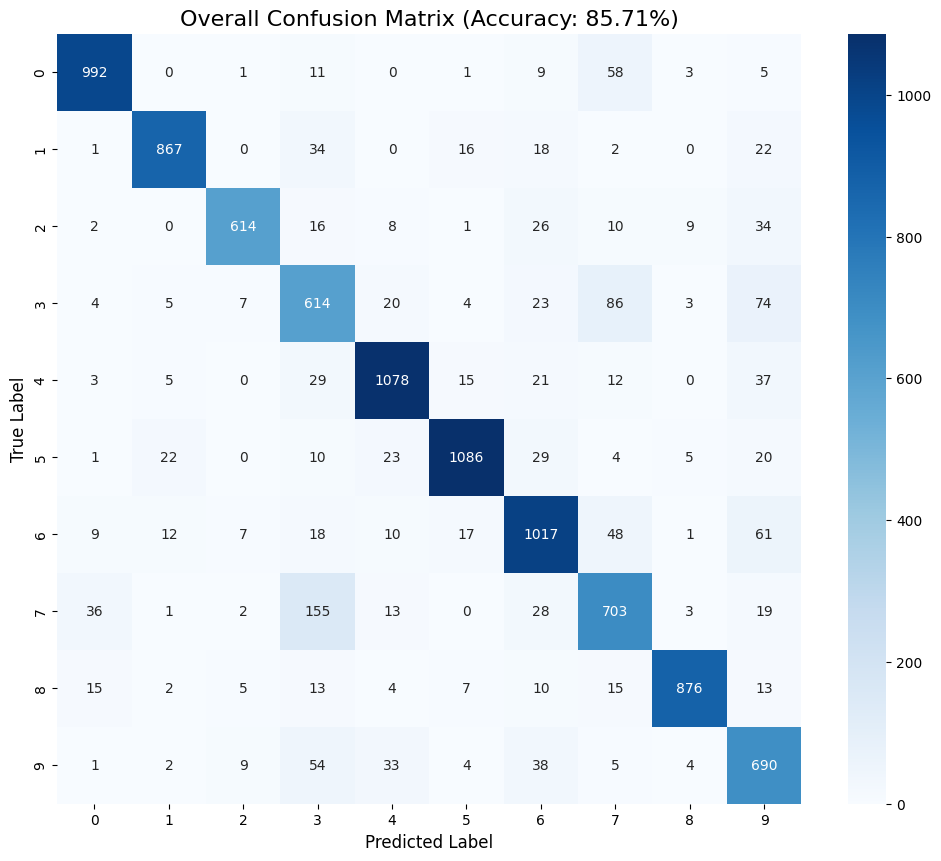

In [8]:
# --- Overall Performance ---
overall_accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"\n--- Overall Model Performance Across {K_FOLDS} Folds ---")
print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(all_true_labels, all_predictions, target_names=class_names))

# --- Confusion Matrix ---
cm = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Overall Confusion Matrix (Accuracy: {overall_accuracy*100:.2f}%)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

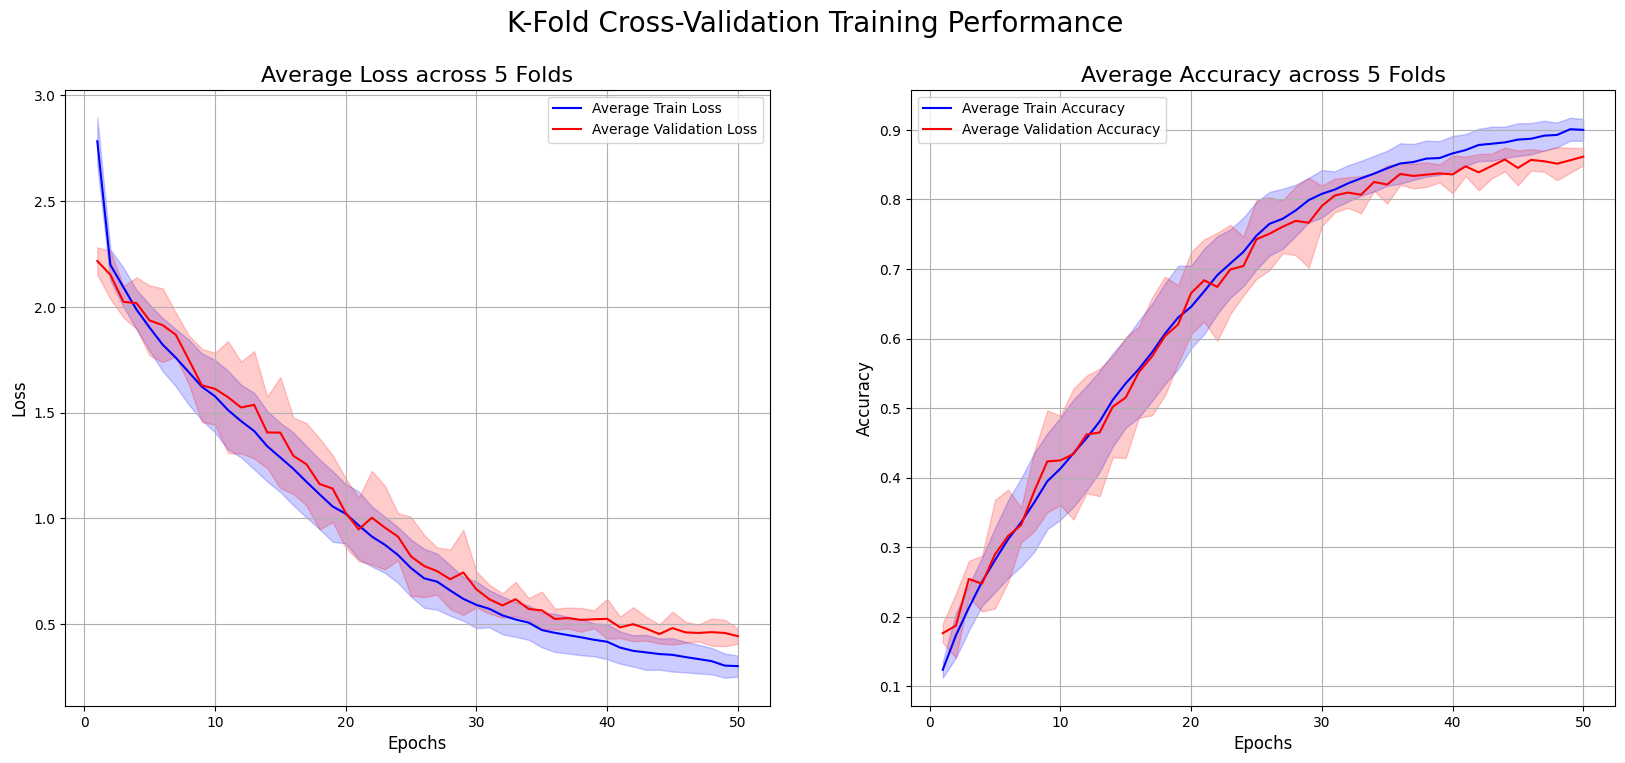

In [9]:
def plot_avg_history(histories):
    max_epochs = max(len(h['train_loss']) for h in histories)
    
    def pad_history(h_list, max_len):
        padded = np.full(max_len, np.nan)
        padded[:len(h_list)] = h_list
        return padded

    avg_train_loss = np.nanmean([pad_history(h['train_loss'], max_epochs) for h in histories], axis=0)
    std_train_loss = np.nanstd([pad_history(h['train_loss'], max_epochs) for h in histories], axis=0)
    avg_val_loss = np.nanmean([pad_history(h['val_loss'], max_epochs) for h in histories], axis=0)
    std_val_loss = np.nanstd([pad_history(h['val_loss'], max_epochs) for h in histories], axis=0)
    avg_train_acc = np.nanmean([pad_history(h['train_acc'], max_epochs) for h in histories], axis=0)
    std_train_acc = np.nanstd([pad_history(h['train_acc'], max_epochs) for h in histories], axis=0)
    avg_val_acc = np.nanmean([pad_history(h['val_acc'], max_epochs) for h in histories], axis=0)
    std_val_acc = np.nanstd([pad_history(h['val_acc'], max_epochs) for h in histories], axis=0)
    
    epochs = range(1, max_epochs + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    ax1.plot(epochs, avg_train_loss, 'b-', label='Average Train Loss')
    ax1.fill_between(epochs, avg_train_loss - std_train_loss, avg_train_loss + std_train_loss, color='b', alpha=0.2)
    ax1.plot(epochs, avg_val_loss, 'r-', label='Average Validation Loss')
    ax1.fill_between(epochs, avg_val_loss - std_val_loss, avg_val_loss + std_val_loss, color='r', alpha=0.2)
    ax1.set_title(f'Average Loss across {K_FOLDS} Folds', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12); ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(); ax1.grid(True)

    ax2.plot(epochs, avg_train_acc, 'b-', label='Average Train Accuracy')
    ax2.fill_between(epochs, avg_train_acc - std_train_acc, avg_train_acc + std_train_acc, color='b', alpha=0.2)
    ax2.plot(epochs, avg_val_acc, 'r-', label='Average Validation Accuracy')
    ax2.fill_between(epochs, avg_val_acc - std_val_acc, avg_val_acc + std_val_acc, color='r', alpha=0.2)
    ax2.set_title(f'Average Accuracy across {K_FOLDS} Folds', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12); ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.legend(); ax2.grid(True)
    
    plt.suptitle('K-Fold Cross-Validation Training Performance', fontsize=20)
    plt.show()

plot_avg_history(fold_histories)